In [23]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/content/drive/MyDrive/Colab Notebooks/data1'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/content/drive/MyDrive/Colab Notebooks/data1/drive/drives1096.png
/content/drive/MyDrive/Colab Notebooks/data1/drive/drives1097.png
/content/drive/MyDrive/Colab Notebooks/data1/drive/drives1089.png
/content/drive/MyDrive/Colab Notebooks/data1/drive/drives1086.jpeg
/content/drive/MyDrive/Colab Notebooks/data1/drive/drives1093.png
/content/drive/MyDrive/Colab Notebooks/data1/drive/drives1088.png
/content/drive/MyDrive/Colab Notebooks/data1/drive/drives1091.png
/content/drive/MyDrive/Colab Notebooks/data1/drive/drives1095.png
/content/drive/MyDrive/Colab Notebooks/data1/drive/drives1092.jpeg
/content/drive/MyDrive/Colab Notebooks/data1/drive/drives1090.png
/content/drive/MyDrive/Colab Notebooks/data1/drive/drives1094.png
/content/drive/MyDrive/Colab Notebooks/data1/drive/drives1084.png
/content/drive/MyDrive/Colab Notebooks/data1/drive/drives1087.png
/content/drive/MyDrive/Colab Notebooks/data1/drive/drives1085.png
/content/drive/MyDrive/Colab Notebooks/data1/drive/drives1079.png
/content

In [24]:
import pandas as pd
import numpy as np
import os, shutil, math, cv2, json, random
from tqdm import tqdm
from keras.layers import *
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator

In [25]:
sdir = '/content/drive/MyDrive/Colab Notebooks/data1'

def make_dataframes(sdir):
    bad_images = []
    good_ext = ['jpg', 'jpeg', 'png', 'tiff']
    filepaths = []
    labels = []
    classes = sorted(os.listdir(sdir))
    for klass in classes:
        classpath = os.path.join(sdir, klass)
        flist = sorted(os.listdir(classpath))
        desc = f'{klass:23s}'
        for f in tqdm(flist, ncols=110, desc=desc, unit='file', colour='blue'):
            fpath = os.path.join(classpath, f)
            fl = f.lower()
            index = fl.rfind('.')
            ext = fl[index + 1:]
            if ext in good_ext:
                try:
                    img = cv2.imread(fpath)
                    shape = img.shape
                    filepaths.append(fpath)
                    labels.append(klass)
                except:
                    bad_images.append(fpath)
                    print('defective image file: ', fpath)
            else:
                bad_images.append(fpath)
    Fseries = pd.Series(filepaths, name='filepaths')
    Lseries = pd.Series(labels, name='labels')
    df = pd.concat([Fseries, Lseries], axis=1)

    train_df, dummy_df = train_test_split(df, train_size=.8, shuffle=True, random_state=123, stratify=df['labels'])
    valid_df, test_df = train_test_split(dummy_df, train_size=.5, shuffle=True, random_state=123,
                                         stratify=dummy_df['labels'])
    classes = sorted(train_df['labels'].unique())
    class_count = len(classes)
    sample_df = train_df.sample(n=50, replace=False)

    ht = 0
    wt = 0
    count = 0
    for i in range(len(sample_df)):
        fpath = sample_df['filepaths'].iloc[i]
        try:
            img = cv2.imread(fpath)
            h = img.shape[0]
            w = img.shape[1]
            wt += w
            ht += h
            count += 1
        except:
            pass
    have = int(ht / count)
    wave = int(wt / count)
    aspect_ratio = have / wave
    print('number of classes in processed dataset= ', class_count)
    counts = list(train_df['labels'].value_counts())
    print('the maximum files in any class in train_df is ', max(counts),
          '  the minimum files in any class in train_df is ', min(counts))
    print('train_df length: ', len(train_df), '  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))
    print('average image height= ', have, '  average image width= ', wave, ' aspect ratio h/w= ', aspect_ratio)
    return train_df, test_df, valid_df, classes, class_count


train_df, test_df, valid_df, classes, class_count = make_dataframes(sdir)

pullshot               : 100%|████████████████████████████████████████████| 100/100 [00:01<00:00, 69.43file/s]


number of classes in processed dataset=  3
the maximum files in any class in train_df is  80   the minimum files in any class in train_df is  80
train_df length:  240   test_df length:  30   valid_df length:  30
average image height=  303   average image width=  337  aspect ratio h/w=  0.8991097922848664


In [26]:
batch_size = 32
img_size = (224, 224)
input_shape = (224, 224, 3)

def make_gens(batch_size, train_df, test_df, valid_df, img_size):
    trgen = ImageDataGenerator(horizontal_flip=True)
    t_and_v_gen = ImageDataGenerator()
    msg = '{0:70s} for train generator'.format(' ')
    print(msg, '\r', end='')  # prints over on the same line
    train_ds = trgen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels',
                                         target_size=img_size, class_mode='categorical',
                                         color_mode='rgb', batch_size=batch_size, shuffle=True)

    msg = '{0:70s} for valid generator'.format(' ')
    print(msg, '\r', end='')  # prints over on the same line
    valid_ds = t_and_v_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels',
                                         target_size=img_size, class_mode='categorical',
                                         color_mode='rgb', batch_size=batch_size, shuffle=False)

    test_len = len(test_df)
    test_batch_size = sorted([int(test_len / n) for n in range(1, test_len + 1)
                              if test_len % n == 0 and test_len / n<=80], reverse=True)[0]
    test_steps = int(test_len / test_batch_size)
    msg = '{0:70s} for test generator'.format(' ')
    print(msg, '\r', end='')  # prints over on the same line
    test_ds = t_and_v_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels',
                                               target_size=img_size, class_mode='categorical',
                                               color_mode='rgb', batch_size=batch_size, shuffle=False)

    classes = list(train_ds.class_indices.keys())
    class_count = len(classes)
    print('test batch size: ', test_batch_size, 'test steps: ', test_steps, 'number of classes : ', class_count)

    return train_ds, test_ds, valid_ds

train_ds, test_ds, valid_ds = make_gens(batch_size, train_df, test_df, valid_df, img_size)

Found 240 validated image filenames belonging to 3 classes.
Found 30 validated image filenames belonging to 3 classes.
Found 30 validated image filenames belonging to 3 classes.
test batch size:  30 test steps:  1 number of classes :  3


In [35]:
import math
import tensorflow as tf
from tensorflow.keras.layers import GlobalAveragePooling2D, Conv2D, BatchNormalization, DepthwiseConv2D, Dropout, Dense, add

def round_filters(filters, multiplier):
    depth_divisor = 8
    min_depth = None
    min_depth = min_depth or depth_divisor
    filters = filters * multiplier
    new_filters = max(min_depth,
                      int(filters + depth_divisor / 2) // depth_divisor * depth_divisor)
    if new_filters < 0.9 * filters:
        new_filters += depth_divisor
    return int(new_filters)

def round_repeats(repeats, multiplier):
    if not multiplier:
        return repeats

    return int(math.ceil(multiplier * repeats))

class SEBlock(tf.keras.layers.Layer):
    def __init__(self, input_channels, ratio=0.25):
        super(SEBlock, self).__init__()
        self.num_reduced_filters = max(1, int(input_channels * ratio))
        self.P1 = GlobalAveragePooling2D()
        self.C1 = Conv2D(filters=self.num_reduced_filters,
                         kernel_size=(1, 1), strides=1, padding='same')
        self.C2 = Conv2D(filters=input_channels, kernel_size=(1, 1),
                         strides=1, padding='same')

    def call(self, inputs, **kwargs):
        x = self.P1(inputs)
        x = tf.expand_dims(input=x, axis=1)
        x = tf.expand_dims(input=x, axis=1)
        x = self.C1(x)
        x = tf.nn.swish(x)
        x = self.C2(x)
        x = tf.nn.sigmoid(x)
        y = inputs * x
        return y

class MBConv(tf.keras.layers.Layer):
    def __init__(self, in_channels, out_channels,
                 expansion_factor, stride, k, drop_connect_rate):
        super(MBConv, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.stride = stride
        self.drop_connect_rate = drop_connect_rate
        self.C1 = Conv2D(filters=in_channels * expansion_factor,
                         kernel_size=(1, 1), strides=1, padding='same', use_bias=False)
        self.B1 = BatchNormalization()
        self.DWC1 = DepthwiseConv2D(kernel_size=(k, k), strides=stride, padding='same',
                                    use_bias=False)
        self.B2 = BatchNormalization()
        self.se = SEBlock(input_channels=in_channels * expansion_factor)
        self.C2 = Conv2D(filters=out_channels, kernel_size=(1, 1),
                         strides=1, padding='same', use_bias=False)
        self.B3 = BatchNormalization()
        self.Dr1 = Dropout(rate=drop_connect_rate)

    def call(self, inputs, training=None, **kwargs):
        x = self.C1(inputs)
        x = self.B1(x, training=training)
        x = tf.nn.swish(x)
        x = self.DWC1(x)
        x = self.B2(x, training=training)
        x = tf.nn.swish(x)
        x = self.se(x)
        x = self.C2(x)
        x = self.B3(x)
        if self.stride == 1 and self.in_channels == self.out_channels:
            if self.drop_connect_rate:
                x = self.Dr1(x, training=training)
            x = add([x, inputs])
        return x

def build_mbconv_block(in_channels, out_channels, layers, stride, expansion_factor, k, drop_connect_rate):
    block = tf.keras.Sequential()
    for i in range(layers):
        if i == 0:
            block.add(MBConv(in_channels=in_channels, out_channels=out_channels,
                             expansion_factor=expansion_factor, stride=stride,
                             k=k, drop_connect_rate=drop_connect_rate))
        else:
            block.add(MBConv(in_channels=in_channels, out_channels=out_channels,
                             expansion_factor=expansion_factor, stride=1,
                             k=k, drop_connect_rate=drop_connect_rate))
    return block

class EfficientNetModel(tf.keras.Model):
    def __init__(self, width_coefficient, depth_coefficient, dropout_rate, num_classes=4, drop_connect_rate=0.2):
        super(EfficientNetModel, self).__init__()

        self.C1 = Conv2D(filters=round_filters(32, width_coefficient), kernel_size=(3, 3), strides=2,
                         padding='same', use_bias=False, input_shape=input_shape)
        self.B1 = BatchNormalization()
        self.block1 = build_mbconv_block(in_channels=round_filters(32, width_coefficient),
                                         out_channels=round_filters(16, width_coefficient),
                                         layers=round_repeats(1, depth_coefficient),
                                         stride=1,
                                         expansion_factor=1, k=3, drop_connect_rate=drop_connect_rate)
        self.block2 = build_mbconv_block(in_channels=round_filters(16, width_coefficient),
                                         out_channels=round_filters(24, width_coefficient),
                                         layers=round_repeats(2, depth_coefficient),
                                         stride=2,
                                         expansion_factor=6, k=3, drop_connect_rate=drop_connect_rate)
        self.block3 = build_mbconv_block(in_channels=round_filters(24, width_coefficient),
                                         out_channels=round_filters(40, width_coefficient),
                                         layers=round_repeats(2, depth_coefficient),
                                         stride=2,
                                         expansion_factor=6, k=5, drop_connect_rate=drop_connect_rate)
        self.block4 = build_mbconv_block(in_channels=round_filters(40, width_coefficient),
                                         out_channels=round_filters(80, width_coefficient),
                                         layers=round_repeats(3, depth_coefficient),
                                         stride=2,
                                         expansion_factor=6, k=3, drop_connect_rate=drop_connect_rate)
        self.block5 = build_mbconv_block(in_channels=round_filters(80, width_coefficient),
                                         out_channels=round_filters(112, width_coefficient),
                                         layers=round_repeats(3, depth_coefficient),
                                         stride=1,
                                         expansion_factor=6, k=5, drop_connect_rate=drop_connect_rate)
        self.block6 = build_mbconv_block(in_channels=round_filters(112, width_coefficient),
                                         out_channels=round_filters(192, width_coefficient),
                                         layers=round_repeats(4, depth_coefficient),
                                         stride=2,
                                         expansion_factor=6, k=5, drop_connect_rate=drop_connect_rate)
        self.block7 = build_mbconv_block(in_channels=round_filters(192, width_coefficient),
                                         out_channels=round_filters(320, width_coefficient),
                                         layers=round_repeats(1, depth_coefficient),
                                         stride=1,
                                         expansion_factor=6, k=3, drop_connect_rate=drop_connect_rate)
        self.C2 = Conv2D(filters=round_filters(1280, width_coefficient), kernel_size=(1, 1),
                         strides=1, padding='same', use_bias=False)
        self.B2 = BatchNormalization()
        self.P1 = GlobalAveragePooling2D()
        self.Dr1 = Dropout(dropout_rate)
        self.D1 = Dense(num_classes, activation='softmax')

    def call(self, inputs, training=None, mask=None):
        x = self.C1(inputs)
        x = self.B1(x, training=training)
        x = tf.nn.swish(x)

        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        x = self.block6(x)
        x = self.block7(x)

        x = self.C2(x)
        x = self.B2(x, training=training)
        x = tf.nn.swish(x)
        x = self.P1(x)
        x = self.Dr1(x)
        y = self.D1(x)

        return y


In [36]:
net = EfficientNetModel(width_coefficient=1.0, depth_coefficient=1.0, dropout_rate=0.2, num_classes=3)

net.compile(optimizer='adam',
            loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
            metrics=['accuracy', 'AUC'])

history = net.fit(train_ds, epochs=5, batch_size=batch_size, validation_data=valid_ds)

net.summary()

Epoch 1/5
8/8 [==============================] - 96s 8s/step - loss: 1.4622 - accuracy: 0.3542 - auc: 0.5217 - val_loss: 1.0993 - val_accuracy: 0.3333 - val_auc: 0.5000
Epoch 2/5
8/8 [==============================] - 61s 7s/step - loss: 1.3204 - accuracy: 0.3000 - auc: 0.4889 - val_loss: 1.0992 - val_accuracy: 0.3333 - val_auc: 0.5000
Epoch 3/5
8/8 [==============================] - 58s 7s/step - loss: 1.0829 - accuracy: 0.4167 - auc: 0.5984 - val_loss: 1.0989 - val_accuracy: 0.3333 - val_auc: 0.5000
Epoch 4/5
8/8 [==============================] - 65s 8s/step - loss: 1.0296 - accuracy: 0.4917 - auc: 0.6677 - val_loss: 1.0992 - val_accuracy: 0.3333 - val_auc: 0.5000
Epoch 5/5
8/8 [==============================] - 61s 7s/step - loss: 0.9918 - accuracy: 0.5250 - auc: 0.7121 - val_loss: 1.0997 - val_accuracy: 0.3333 - val_auc: 0.5000
Model: "efficient_net_model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Par

In [37]:
def GELU(x):
    res = 0.5 * x * (1 + tf.nn.tanh(math.sqrt(2 / math.pi) * (x + 0.044715 * (x ** 3))))
    return res


# 定义残差MLP结构块
class ResMLPBlock(tf.keras.layers.Layer):
    def __init__(self, units, residual_path):
        super(ResMLPBlock, self).__init__()
        self.residual_path = residual_path
        self.D1 = Dense(units, activation='relu')
        self.D2 = Dense(units, activation='relu')

        if self.residual_path:
            self.D3 = Dense(units)
            self.D4 = Dense(units)

    def call(self, inputs):
        residual = inputs

        x = self.D1(inputs)
        y = self.D2(x)

        if self.residual_path:
            residual = self.D3(inputs)
            residual = GELU(residual)
            residual = self.D4(residual)
            residual = GELU(residual)

        output = y + residual
        return output

class ResMLP(tf.keras.layers.Layer):
    def __init__(self, initial_filters, block_list, num_classes):
        super(ResMLP, self).__init__()
        self.initial_filters = initial_filters
        self.block_list = block_list

        self.D1 = Dense(self.initial_filters, activation='relu')
        self.B1 = BatchNormalization()

        self.blocks = tf.keras.models.Sequential()
        for block_id in range(len(block_list)):
            for layer_id in range(block_list[block_id]):
                if block_id != 0 and layer_id == 0:
                    block = ResMLPBlock(units=self.initial_filters, residual_path=True)
                else:
                    block = ResMLPBlock(units=self.initial_filters, residual_path=False)
                self.blocks.add(block)
            self.initial_filters *= 2

        self.D2 = Dense(4, activation='softmax')


    def call(self, inputs):
        x = self.D1(inputs)
        x = self.B1(x)
        x = self.blocks(x)
        y = self.D2(x)
        return y

In [42]:
def make_model(input_shape):
    base_model=tf.keras.applications.efficientnet.EfficientNetB3(include_top=False, weights="imagenet",input_shape=input_shape, pooling='max')

    base_model.trainable=True
    x=base_model.output
    output=ResMLP(initial_filters=32, block_list=[2, 2, 2], num_classes=4)(x)
    model=tf.keras.models.Model(inputs=base_model.input, outputs=output)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', 'AUC'])
    return model

model=make_model(input_shape)

In [57]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

# Assuming you have loaded your dataset as train_ds and valid_ds

num_classes = 3  # Number of classes in your reduced dataset
input_shape = (224, 224, 3)  # Adjust this according to your input data shape

# Create your model
model = Sequential([
    # Adjust input_shape according to your input data
    Flatten(input_shape=input_shape),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')  # Output layer with 3 units for 3 classes
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy', tf.keras.metrics.AUC()])

# Define other parameters
batch_size = 32
num_epochs = 5

# Checkpoint path
checkpoint_save_path = './checkpoint/ResMLP.ckpt'

# Load model weights if available
if os.path.exists(checkpoint_save_path + '.index'):
    print('-------------------------------------Loading-------------------------------------')
    model.load_weights(checkpoint_save_path)

# Callback for model checkpoint
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_save_path,
                                                 save_weights_only=True,
                                                 save_best_only=True)

# Train the model with the reduced dataset
history = model.fit(
    train_ds,
    epochs=num_epochs,
    batch_size=batch_size,
    validation_data=valid_ds,
    callbacks=[cp_callback]
)

# Display model summary
model.summary()

# Save model's trainable variables to a file
file = open('./weights.txt', 'w')
for v in model.trainable_variables:
    file.write(str(v.name) + '\n')
    file.write(str(v.shape) + '\n')
    file.write(str(v.numpy()) + '\n')
file.close()


-------------------------------------Loading-------------------------------------
Epoch 1/5
8/8 [==============================] - 9s 895ms/step - loss: 914.1497 - accuracy: 0.7083 - auc: 0.7838 - val_loss: 540.8245 - val_accuracy: 0.6667 - val_auc: 0.7500
Epoch 2/5
8/8 [==============================] - 5s 628ms/step - loss: 602.9830 - accuracy: 0.7500 - auc: 0.8125 - val_loss: 274.8651 - val_accuracy: 0.8333 - val_auc: 0.8750
Epoch 3/5
8/8 [==============================] - 5s 608ms/step - loss: 509.9646 - accuracy: 0.7583 - auc: 0.8187 - val_loss: 511.1186 - val_accuracy: 0.7667 - val_auc: 0.8250
Epoch 4/5
8/8 [==============================] - 7s 867ms/step - loss: 378.4984 - accuracy: 0.7792 - auc: 0.8344 - val_loss: 188.5799 - val_accuracy: 0.8333 - val_auc: 0.8750
Epoch 5/5
8/8 [==============================] - 4s 507ms/step - loss: 308.3469 - accuracy: 0.8375 - auc: 0.8781 - val_loss: 340.2476 - val_accuracy: 0.8000 - val_auc: 0.8500
Model: "sequential_24"
____________________

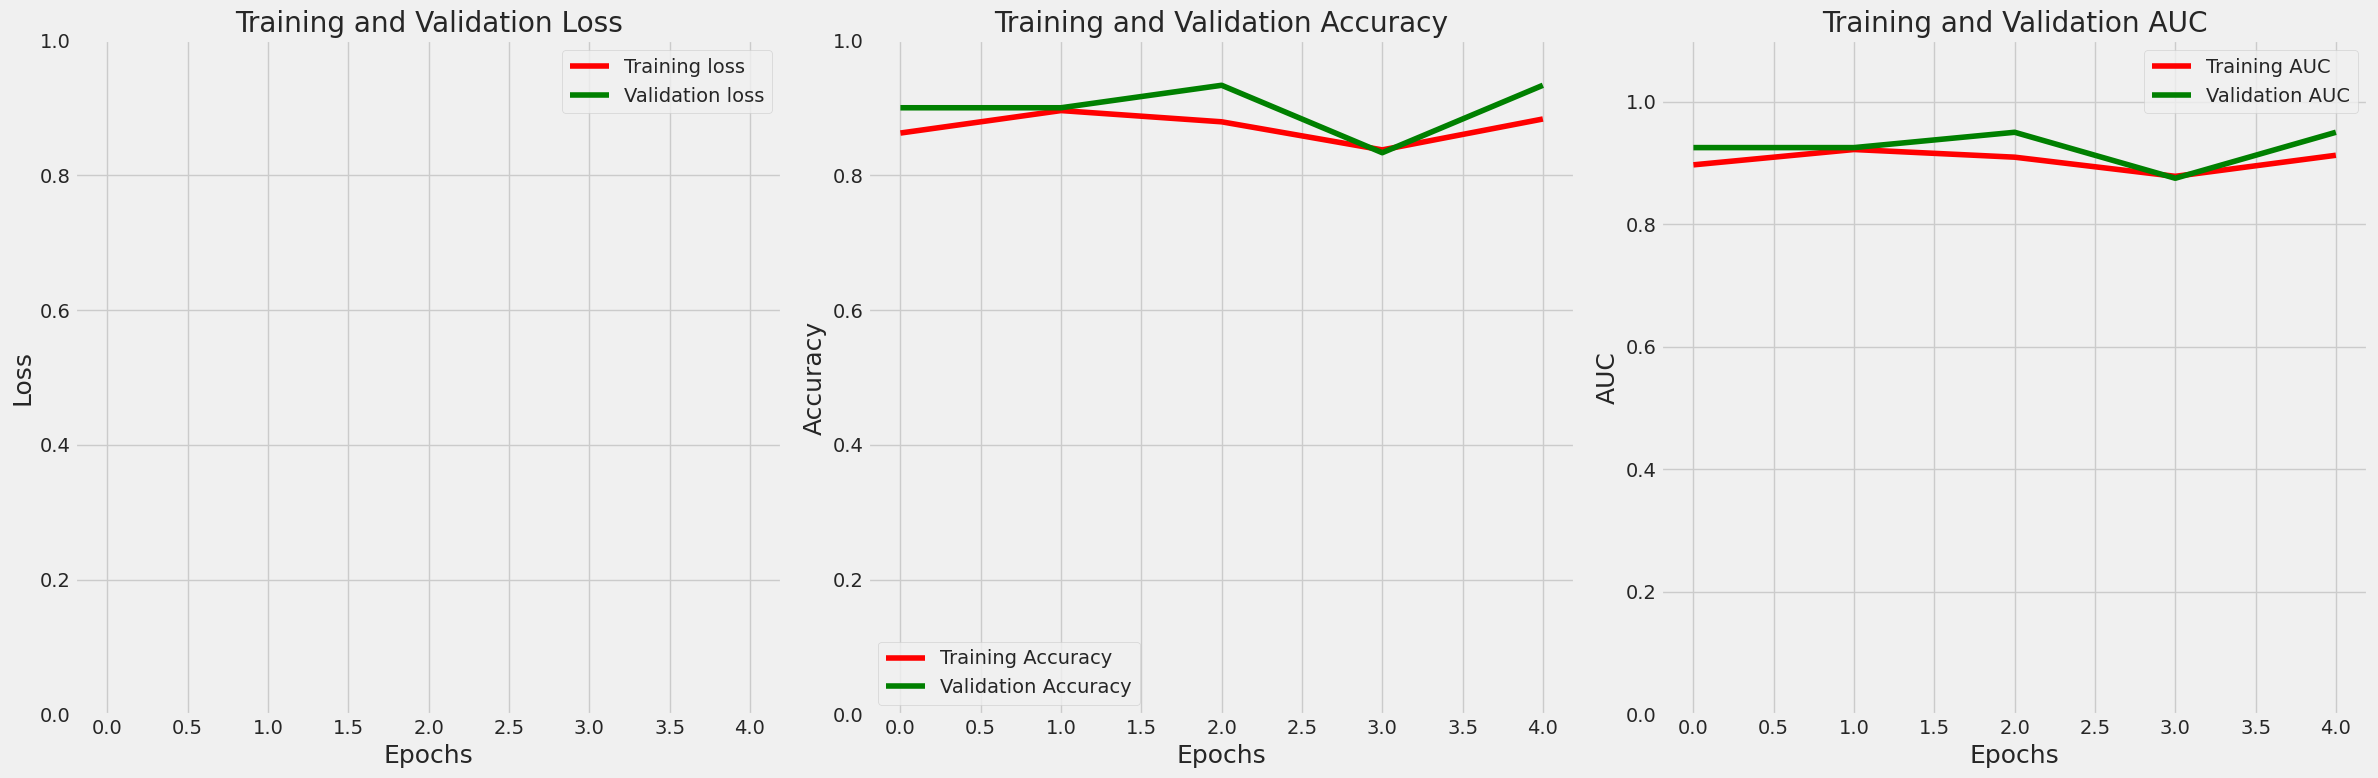

In [65]:
def plot_auc_acc_loss(history, epochs):
    tacc = history.history['accuracy']
    tloss = history.history['loss']
    tauc = history.history['auc']

    vacc = history.history['val_accuracy']
    vloss = history.history['val_loss']
    vauc = history.history['val_auc']

    Epochs = [i for i in range(epochs)]

    plt.style.use('fivethirtyeight')
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(24, 8))
    axes[0].plot(Epochs, tloss, 'r', label='Training loss')
    axes[0].plot(Epochs, vloss, 'g', label='Validation loss')
    axes[0].set_ylim(0, 1)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs', fontsize=18)
    axes[0].set_ylabel('Loss', fontsize=18)
    axes[0].legend()

    axes[1].plot(Epochs, tacc, 'r', label='Training Accuracy')
    axes[1].plot(Epochs, vacc, 'g', label='Validation Accuracy')
    axes[1].set_ylim(0, 1)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs', fontsize=18)
    axes[1].set_ylabel('Accuracy', fontsize=18)
    axes[1].legend()

    axes[2].plot(Epochs, tauc, 'r', label='Training AUC')
    axes[2].plot(Epochs, vauc, 'g', label='Validation AUC')
    axes[2].set_ylim(0, 1.1)
    axes[2].set_title('Training and Validation AUC')
    axes[2].set_xlabel('Epochs', fontsize=18)
    axes[2].set_ylabel('AUC', fontsize=18)
    axes[2].legend()

    plt.tight_layout()
    plt.show()

    return Epochs

Epochs = plot_auc_acc_loss(history, epochs=5)

Epoch 1/5
8/8 [==============================] - 7s 831ms/step - loss: 239.9963 - accuracy: 0.8625 - auc: 0.8969 - val_loss: 172.3973 - val_accuracy: 0.9000 - val_auc: 0.9250
Epoch 2/5
8/8 [==============================] - 5s 572ms/step - loss: 123.1167 - accuracy: 0.8958 - auc: 0.9219 - val_loss: 109.0906 - val_accuracy: 0.9000 - val_auc: 0.9250
Epoch 3/5
8/8 [==============================] - 5s 681ms/step - loss: 140.6603 - accuracy: 0.8792 - auc: 0.9094 - val_loss: 81.1195 - val_accuracy: 0.9333 - val_auc: 0.9500
Epoch 4/5
8/8 [==============================] - 5s 629ms/step - loss: 178.9988 - accuracy: 0.8375 - auc: 0.8781 - val_loss: 298.7689 - val_accuracy: 0.8333 - val_auc: 0.8750
Epoch 5/5
8/8 [==============================] - 4s 504ms/step - loss: 125.5872 - accuracy: 0.8833 - auc: 0.9125 - val_loss: 107.3107 - val_accuracy: 0.9333 - val_auc: 0.9500
Available keys in history object: dict_keys(['loss', 'accuracy', 'auc', 'val_loss', 'val_accuracy', 'val_auc'])


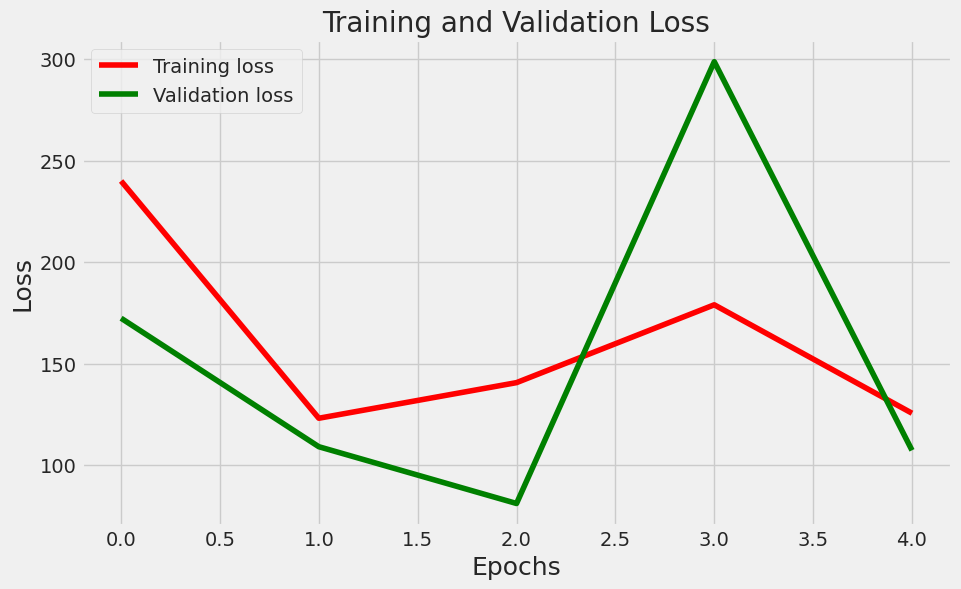

In [62]:
import tensorflow as tf
import matplotlib.pyplot as plt

# Your code for data preprocessing, model building, and training

# Define a function to plot the training and validation loss
def plot_loss(history, epochs):
    available_keys = history.history.keys()
    print("Available keys in history object:", available_keys)

    tloss = history.history['loss']
    vloss = history.history['val_loss']

    Epochs = [i for i in range(epochs)]

    plt.style.use('fivethirtyeight')
    plt.figure(figsize=(10, 6))
    plt.plot(Epochs, tloss, 'r', label='Training loss')
    plt.plot(Epochs, vloss, 'g', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs', fontsize=18)
    plt.ylabel('Loss', fontsize=18)
    plt.legend()
    plt.show()

    return Epochs

# Train the model
history = model.fit(train_ds, epochs=5, validation_data=valid_ds)

# Plot the loss
Epochs = plot_loss(history, epochs=5)

# Continue with the rest of your code
# Save model, export results, or perform further analysis


1/1 [==============================] - 0s 474ms/step
there were 5 errors in 30 tests for an accuracy of  83.33%


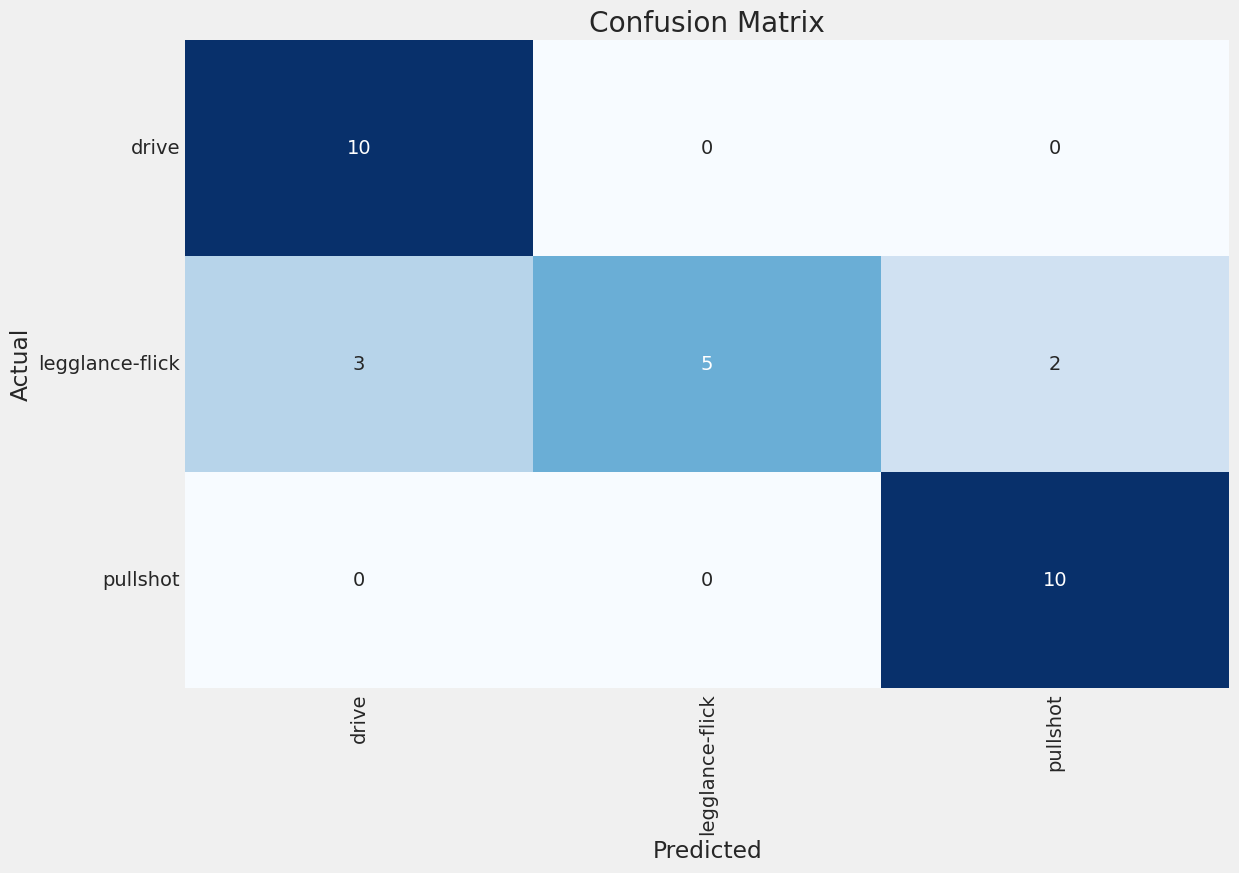

Classification Report:
----------------------
                  precision    recall  f1-score   support

          drive     0.7692    1.0000    0.8696        10
legglance-flick     1.0000    0.5000    0.6667        10
       pullshot     0.8333    1.0000    0.9091        10

       accuracy                         0.8333        30
      macro avg     0.8675    0.8333    0.8151        30
   weighted avg     0.8675    0.8333    0.8151        30



In [67]:
def predictor(test_ds):
    y_pred, error_list, error_pred_list = [], [], []
    y_true = test_ds.labels
    classes = list(test_ds.class_indices.keys())
    class_count = len(classes)
    errors = 0
    preds = tf.argmax(model.predict(test_ds), axis=1)
    tests = len(preds)
    for i in range(tests):
        pred_index = preds[i]
        true_index = test_ds.labels[i]
        if pred_index != true_index:
            errors += 1
            file = test_ds.filenames[i]
            error_list.append(file)
            error_classes = classes[pred_index]
            error_pred_list.append(error_classes)
        y_pred.append(pred_index)

    acc = (1 - errors / tests) * 100
    msg = f'there were {errors} errors in {tests} tests for an accuracy of {acc:6.2f}%'
    print(msg)
    ypred = np.array(y_pred)
    ytrue = np.array(y_true)
    f1score = f1_score(ytrue, ypred, average='weighted') * 100

    if class_count <= 30:
        cm = confusion_matrix(y_true, y_pred)

        plt.figure(figsize=(12, 8))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
        plt.xticks(np.arange(class_count) + .5, classes, rotation=90)
        plt.yticks(np.arange(class_count) + .5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()

    clr = classification_report(y_true, y_pred, target_names=classes, digits=4)
    print("Classification Report:\n----------------------\n", clr)

    return errors, tests, error_list, error_pred_list, f1score

errors, tests, error_list, error_pred_list, f1score = predictor(test_ds)

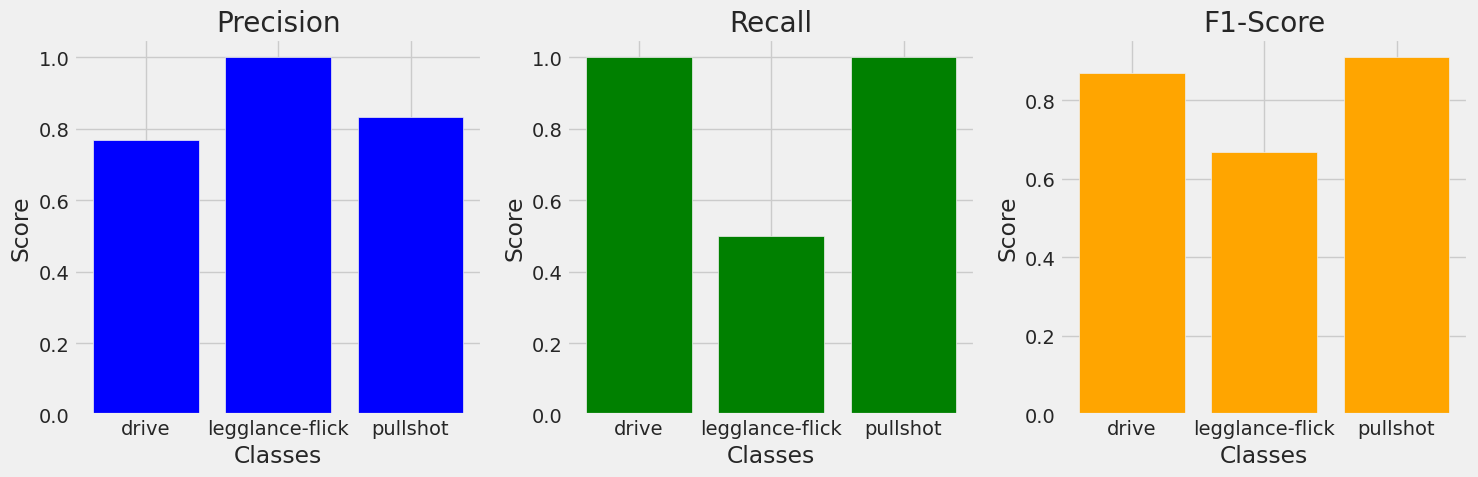

In [80]:
import matplotlib.pyplot as plt

# Replace these values with the precision, recall, and F1-score from your classification report
precision = [0.7692, 1.0000, 0.8333]
recall = [1.0000, 0.5000, 1.0000]
f1_score = [0.8696, 0.6667, 0.9091]
class_names = ['drive', 'legglance-flick', 'pullshot']

# Create subplots for precision, recall, and F1-score
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot precision
axs[0].bar(class_names, precision, color='blue')
axs[0].set_title('Precision')
axs[0].set_xlabel('Classes')
axs[0].set_ylabel('Score')

# Plot recall
axs[1].bar(class_names, recall, color='green')
axs[1].set_title('Recall')
axs[1].set_xlabel('Classes')
axs[1].set_ylabel('Score')

# Plot F1-score
axs[2].bar(class_names, f1_score, color='orange')
axs[2].set_title('F1-Score')
axs[2].set_xlabel('Classes')
axs[2].set_ylabel('Score')

plt.tight_layout()
plt.show()
